In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap
from jax import jit, lax, grad
import matplotlib.pyplot as plt
import cmocean as cmo
import importlib
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import stopro.data_generator.sinusoidal as sinusoidal
from stopro.data_generator.sin_1D_naive import Sin1DNaive
from stopro.data_generator.sin_1D import Sin1D
from stopro.sub_modules.load_modules import load_params, load_data
from stopro.sub_modules.loss_modules import hessian, logposterior
from stopro.sub_modules.init_modules import get_init, reshape_init
import stopro.GP.gp_sinusoidal_independent as gp_sinusoidal_independent
import stopro.GP.gp_1D_naive as gp_1D_naive
from stopro.data_handler.data_handle_module import HdfOperator
from stopro.GP.kernels import define_kernel
from stopro.solver.optimizers import optimize_by_adam
import stopro.GP.gp_1D_laplacian as gp_1D_laplasian
import stopro.data_preparer.data_preparer as data_preparer

In [3]:
## import modules
import bbmm.utils.preconditioner as precond
import bbmm.utils.conjugate_gradient as cg
import bbmm.functions.pivoted_cholesky_jax as pc_jax
import bbmm.functions.pivoted_cholesky_numpy as pcn
import bbmm.utils.calc_logdet as calc_logdet
import bbmm.utils.calc_trace as calc_trace

# import bbmm.operators.dense_linear_operator as dense_linear_operator
# import bbmm.operators.root_linear_operator as root_linear_operator
# import bbmm.operators.diag_linear_operator as diag_linear_operator
# import bbmm.operators._linear_operator as _linear_operator
# import bbmm.operators.psd_sum_linear_operator as psd_sum_linear_operator
# import bbmm.operators.root_linear_operator as root_linear_operator
# from bbmm.functions.pivoted_cholesky_numpy import pivoted_cholesky_numpy
def reload():
    importlib.reload(precond)
    importlib.reload(cg)
    importlib.reload(pc_jax)
    importlib.reload(calc_logdet)
    importlib.reload(calc_trace)
    importlib.reload(pcn)
    # importlib.reload(dense_linear_operator)
    # importlib.reload(root_linear_operator)
    # importlib.reload(diag_linear_operator)
    # importlib.reload(_linear_operator)
    # importlib.reload(psd_sum_linear_operator)
    # importlib.reload(root_linear_operator)
    importlib.reload(sinusoidal)
reload()

In [4]:
def is_positive_definite(matrix):
    # 行列の固有値を計算
    eigenvalues = np.linalg.eigvals(matrix)

    # 全ての固有値が正であるかをチェック
    if np.all(eigenvalues > 0):
        return True
    else:
        return False

In [5]:
def rel_error(true, pred):
    true_max = np.max(true)
    zero_threshold = (
        true_max * 1e-7
    )  # ignore the data that test value is smaller than 1e-7
    index = np.where(abs(true) > zero_threshold)
    if np.all(abs(true) <= zero_threshold):
        rel_error = 0.0
        return rel_error
    true2 = true[index]
    pred2 = pred[index]
    rel_error = np.abs((true2 - pred2) / true2)
    # print(rel_error)
    return rel_error

In [10]:
project_name = 'tests/data'
simulation_name = 'sinusoidal_direct'

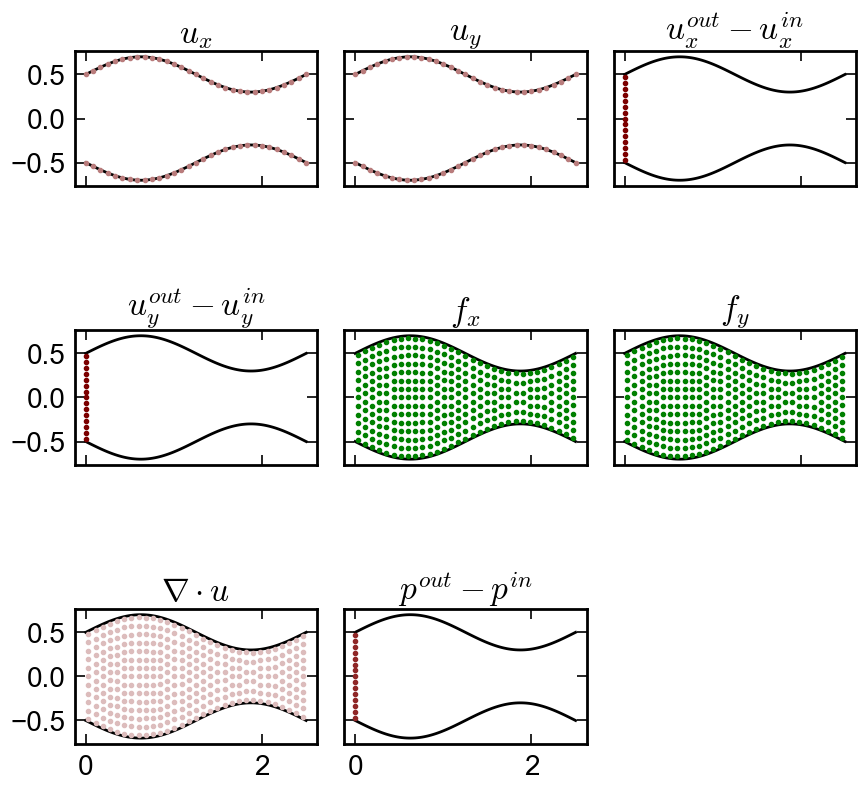

In [12]:
data_preparer_sinusoidal = data_preparer.DataPreparer(
    project_name, simulation_name, class_data_generator=sinusoidal.Sinusoidal)
data_preparer_sinusoidal.load_params(
    system_name="sinusoidal", use_existing_params=False
)
# data_preparer_sinusoidal.params_generate_training['u_num'] = 20
# data_preparer_sinusoidal.params_generate_training['difu_num'] = 8
# data_preparer_sinusoidal.params_generate_training['difp_num'] = 8
# data_preparer_sinusoidal.params_generate_training['f_num'] = 26 # 21
# data_preparer_sinusoidal.params_generate_training['div_num'] = 26
# data_preparer_sinusoidal.params_generate_training['f_pad'] = 0.06
# data_preparer_sinusoidal.params_generate_training['div_pad'] = 0.06
# # data_preparer_sinusoidal.params_generate_training['difu_pad'] = 0.03
# data_preparer_sinusoidal.params_generate_training['difp_pad'] = 0.03

data_preparer_sinusoidal.params_generate_test['test_num'] = 18


# data_preparer_sinusoidal.create_directory()

r_train, f_train, r_test, f_test = data_preparer_sinusoidal.make_data(
    save_data=False, 
    return_data=True,
    plot_training=True,
    save_plot=False,
)
scale = 7.

delta_y_train = jnp.empty(0)
for i in range(len(r_train)):
    delta_y_train = jnp.append(
        delta_y_train, f_train[i] / scale
)
μ_test = [jnp.zeros(len(_r)) for _r in r_test]
r_train= [_r * scale for _r in r_train]
r_test = [_r * scale for _r in r_test]
data_preparer_sinusoidal.save_params_prepare()
data_preparer_sinusoidal.save_params_main()
data_preparer_sinusoidal.save_lbls()

In [13]:
params_main, params_prepare, lbls = load_params(f"{project_name}/{simulation_name}/data_input")
params_model = params_main["model"]
params_optimization = params_main["optimization"]
params_plot = params_prepare["plot"]
vnames = params_prepare["vnames"]
params_setting = params_prepare["setting"]
params_generate_training = params_prepare["generate_training"]
params_generate_test = params_prepare["generate_test"]
params_kernel_arg = params_prepare["kernel_arg"]

# prepare initial hyper-parameter
init = get_init(
    params_model["init_kernel_hyperparameter"],
    params_model["kernel_type"],
    system_type=params_model["system_type"],
)

In [22]:
params_model["epsilon"] = 1e-06
args_predict = r_test, μ_test, r_train, delta_y_train, params_model["epsilon"]

In [17]:
# setup model
Kernel = define_kernel(params_model)
gp_model = gp_sinusoidal_independent.GPSinusoidalWithoutPIndependent(
    use_difp=params_setting["use_difp"],
    use_difu=params_setting["use_difu"],
    lbox=jnp.array([2.5*scale, 0.0]),
    infer_governing_eqs=params_prepare["generate_test"]["infer_governing_eqs"],
    Kernel=Kernel,
    index_optimize_noise=params_model["index_optimize_noise"],
)
gp_model.set_constants(*args_predict)
gp_model.set_constants(*args_predict)
loglikelihood, predictor = (
    gp_model.trainingFunction_all,
    gp_model.predictingFunction_all,
)
func = jit(logposterior(loglikelihood, params_optimization))
dfunc = jit(grad(func, 0))
hess = hessian(func)

## check K^{-1}y with precondition

In [92]:
cov_scale = 1.
length = 0.4
init = jnp.array([cov_scale, length, length, cov_scale, length, length, cov_scale, length, length])

In [93]:
theta_optimized = jnp.array([2.225, 0.624, 0.307, -0.223, 0.542, 0.309, 2.767, 0.800, 1.019])

In [94]:
_K = gp_model.trainingK_all(init, r_train)
K = gp_model.add_eps_to_sigma(_K, params_model["epsilon"], noise_parameter=None)

In [95]:
print(is_positive_definite(K))
print(f"{jnp.linalg.cond(K):.3e}")

True
8.595e+07


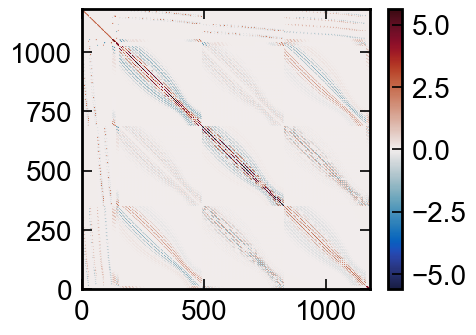

In [96]:
fig, ax = plt.subplots(figsize=(5, 4))
mappable = ax.pcolormesh(np.flipud(K), vmin=-np.max(K), vmax=np.max(K), cmap=cmo.cm.balance)
fig.colorbar(mappable)

In [97]:
rank=15
precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(_K, rank=rank, noise=params_model["epsilon"], min_preconditioning_size=1)

In [98]:
print(is_positive_definite(precondition(K)))
print(f"{jnp.linalg.cond(precondition(K)):.3e}")
# precondition still doesn't work

True
2.268e+08


In [99]:
def setup_loss_mpcg(rank=15, n_tridiag=10, seed=0, cg_tolerance=0.01, max_tridiag_iter=20, min_preconditioning_size=2000, max_iter_cg=1000):
    def loss_mpcg(init, *args):
        r, delta_y, noise = args

        K = gp_model.trainingK_all(init, r)
        K = gp_model.add_eps_to_sigma(K, noise, noise_parameter=None)
        
        precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, noise=noise, min_preconditioning_size=min_preconditioning_size, func_pivoted_cholesky=pc_jax.pivoted_cholesky_jax)
        zs = jax.random.normal(jax.random.PRNGKey(seed), (len(delta_y), n_tridiag))
        if precondition:
            zs = precond_lt.zero_mean_mvn_samples(n_tridiag)
        # else:
        #     zs = jax.random.normal(jax.random.PRNGKey(seed), (len(delta_y), n_tridiag))
        zs_norm = jnp.linalg.norm(zs, axis=0)
        zs = zs / zs_norm
        rhs = jnp.concatenate([zs, delta_y.reshape(-1, 1)], axis=1)
        Kinvy, j,t_mat = cg.mpcg_bbmm(
            K,
            rhs,
            precondition=precondition, 
            print_process=False, 
            tolerance=cg_tolerance, 
            n_tridiag=n_tridiag, 
            max_tridiag_iter=max_tridiag_iter,
            max_iter_cg=max_iter_cg
        )

        logdet = calc_logdet.calc_logdet(K.shape, t_mat, precond_logdet_cache)
        yKy = jnp.dot(delta_y, Kinvy[:, -1])
        loss = ((yKy + logdet)/2 + len(delta_y)/2*jnp.log(jnp.pi*2))
        # print(yKy)
        # print(logdet)
        return loss
    return loss_mpcg

In [100]:
loglikelihood_mpcg = setup_loss_mpcg(
    rank=15,
    n_tridiag=20, 
    max_tridiag_iter=40, 
    cg_tolerance=1, 
    min_preconditioning_size=1,
    max_iter_cg=2000,
)

In [101]:
func_mpcg = logposterior(loglikelihood_mpcg, params_optimization)
dfunc_mpcg = jit(grad(func_mpcg, 0))
hess_mpcg= hessian(func_mpcg)

In [102]:
params_optimization["lr"] = 1e-02
params_optimization["print_process"] = True

params_optimization["maxiter_scipy"] = [0]
params_optimization["maxiter_GD"] = 5

In [103]:
opts = [{"x": init}]
opt, loss, theta, norm_of_grads_list = optimize_by_adam(
    func, dfunc, hess, init, params_optimization, *args_predict[2:]
)

loss before optimize: -1.3841368794177857
step   0 loss: -1.3841 max_grad: 1.53058, arg=2
norm_of_grads: 1.99865
[1.01 0.39 0.39 0.99 0.41 0.41 1.01 0.41 0.41]
step   1 loss: -1.4237 max_grad: 1.20478, arg=2
norm_of_grads: 1.52857
[1.02   0.3804 0.3801 0.9803 0.4197 0.4199 1.02   0.42   0.42  ]
step   2 loss: -1.4528 max_grad: 0.92296, arg=2
norm_of_grads: 1.12852
[1.0298 0.3716 0.3705 0.9713 0.4286 0.4294 1.03   0.4299 0.4298]
step   3 loss: -1.4721 max_grad: 0.68568, arg=2
norm_of_grads: 0.83657
[1.0396 0.3643 0.3612 0.9641 0.4355 0.4383 1.04   0.4398 0.4392]
step   4 loss: -1.4835 max_grad: 0.49179, arg=2
norm_of_grads: 0.70722
[1.0492 0.359  0.3524 0.9598 0.4392 0.4461 1.0501 0.4496 0.4478]


In [104]:
opts = [{"x": init}]
# np.arrayのinstanceを生成している文章があると，jax.gradを使うことができない
opt, loss, theta, norm_of_grads_list = optimize_by_adam(
    func_mpcg, dfunc_mpcg, hess_mpcg, init, params_optimization, *args_predict[2:]
)

loss before optimize: -0.47733420177324165
step   0 loss: -0.4773 max_grad: 0.82601, arg=1
norm_of_grads: 1.31912
[0.99 0.41 0.41 0.99 0.41 0.41 0.99 0.41 0.41]
step   1 loss: -0.5119 max_grad: 0.80910, arg=5
norm_of_grads: 1.27728
[0.9964 0.4199 0.42   0.98   0.42   0.42   0.98   0.4199 0.42  ]
step   2 loss: -0.5375 max_grad: 0.89863, arg=5
norm_of_grads: 1.21692
[1.0042 0.4293 0.43   0.9701 0.4297 0.43   0.97   0.4296 0.43  ]
step   3 loss: -0.5666 max_grad: 0.76037, arg=1
norm_of_grads: 1.20969
[1.0108 0.4389 0.4394 0.9605 0.4395 0.4399 0.9603 0.4394 0.4399]
step   4 loss: -0.5846 max_grad: 0.74960, arg=1
norm_of_grads: 1.20133
[1.0167 0.4487 0.4478 0.9509 0.4494 0.4496 0.9507 0.4493 0.4498]


## check if we can reach convergenparams_optimization

In [105]:
params_optimization["eps"] = 0.0001
params_optimization["maxiter_GD"] = 900
params_optimization["print_process"] = False

In [106]:
opts = [{"x": init}]
opt, loss, theta, norm_of_grads_list = optimize_by_adam(
    func, dfunc, hess, init, params_optimization, *args_predict[2:]
)

loss before optimize: -1.3841368794177857
converged


In [107]:
len(loss)

325

In [108]:
params_optimization["maxiter_GD"] = 900
params_optimization["print_process"] = False
opts = [{"x": init}]
opt_mpcg, loss_mpcg, theta_mpcg, norm_of_grads_list_mpcg = optimize_by_adam(
    func_mpcg, dfunc_mpcg, hess_mpcg, init, params_optimization, *args_predict[2:]
)

loss before optimize: -0.47733420177324165
converged


In [109]:
len(loss_mpcg)

142

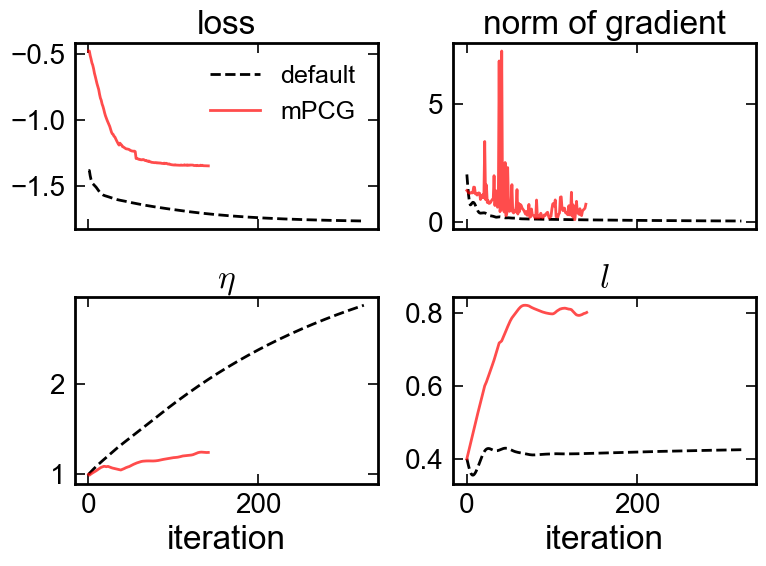

In [111]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8, 6), sharex=True)
kwargs = {"linestyle": "--"}
kwargs_mpcg = {"alpha": 0.7}

axs[0][0].plot(loss, **kwargs, label='default')
axs[0][0].plot(loss_mpcg, label='mPCG', **kwargs_mpcg)
axs[0][0].set_title('loss')

axs[0][1].plot(norm_of_grads_list, **kwargs, label='default')
axs[0][1].plot(norm_of_grads_list_mpcg, label='mPCG', **kwargs_mpcg)
axs[0][1].set_title('norm of gradient')

                    
axs[1][0].plot(np.array(theta)[:, 0], **kwargs)
axs[1][0].plot(np.array(theta_mpcg)[:, 0], **kwargs_mpcg)
axs[1][0].set_title('$\eta$')
axs[1][0].set_xlabel('iteration')

axs[1][1].plot(np.array(theta)[:, 1], **kwargs)
axs[1][1].plot(np.array(theta_mpcg)[:, 1], **kwargs_mpcg)
axs[1][1].set_title('$l$')
axs[1][1].set_xlabel('iteration')

axs[0][0].legend()
plt.tight_layout()

In [117]:
def setup_predictor_mpcg(rank=15, n_tridiag=10, seed=0, cg_tolerance=0.01, max_tridiag_iter=20, min_preconditioning_size=2000, max_iter_cg=1000):
    def predictor_mpcg(opt, *args):

        r_test, μ_test, r, delta_y, noise = args

        K = gp_model.trainingK_all(opt, r)
        K = gp_model.add_eps_to_sigma(K, noise, noise_parameter=None)
        
        Kab = gp_model.mixedK_all(opt, r_test, r_train)
        Kaa = gp_model.testK_all(opt, r_test)
        
        precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, noise=noise, min_preconditioning_size=min_preconditioning_size, func_pivoted_cholesky=pc_jax.pivoted_cholesky_jax)
        zs = jax.random.normal(jax.random.PRNGKey(seed), (len(delta_y), n_tridiag))
        if precondition:
            zs = precond_lt.zero_mean_mvn_samples(n_tridiag)
        # else:
        #     zs = jax.random.normal(jax.random.PRNGKey(seed), (len(delta_y), n_tridiag))
        zs_norm = jnp.linalg.norm(zs, axis=0)
        zs = zs / zs_norm
        rhs = jnp.concatenate([delta_y.reshape(-1, 1)], axis=1)
        Kinvy, j = cg.mpcg_bbmm(
            K,
            rhs,
            precondition=precondition, 
            print_process=False, 
            tolerance=cg_tolerance, 
            n_tridiag=0, 
            max_tridiag_iter=max_tridiag_iter,
            max_iter_cg=max_iter_cg
        )
        rhs = Kab.T

        # Kinvk, j = cg.mpcg_bbmm(
        #     K,
        #     rhs,
        #     precondition=precondition, 
        #     print_process=False, 
        #     tolerance=cg_tolerance, 
        #     n_tridiag=0,
        #     max_tridiag_iter=max_tridiag_iter,
        #     max_iter_cg=max_iter_cg
        # )


        kKy = jnp.squeeze(jnp.matmul(Kab, Kinvy), axis=1)
        # kKk = jnp.matmul(Kab, Kinvk)
        print(kKy.shape)
        sec0 = 0
        sec1 = 0
        fs_mpcg = []
        Sigmas_mpcg = []
        for i in range(len(r_test)):
            sec1 += len(r_test[i])
            fs_mpcg.append(μ_test[0] + kKy[sec0:sec1])
            # Sigmas_mpcg.append(Kaa[sec0:sec1, sec0:sec1] - kKk[sec0:sec1, sec0:sec1])
            sec0 += len(r_test[i])
        # f_infer_mpcg = [μ_test[0] + jnp.squeeze(kKy, axis=1)]
        # Sigma_mpcg = Kaa - kKk
        # print(yKy)
        # print(logdet)
        return fs_mpcg, Sigmas_mpcg
    return predictor_mpcg

In [134]:
predictor_mpcg = setup_predictor_mpcg(rank=50,
    n_tridiag=20, 
    max_tridiag_iter=40, 
    cg_tolerance=0.01, 
    min_preconditioning_size=1,
    max_iter_cg=10000,
)
fs_mpcg, Sigma_mpcg = predictor_mpcg(opt_mpcg, *args_predict)
# std_mpcg = jnp.sqrt(jnp.diag(Sigma_mpcg))

(1152,)


In [135]:
fs, Σs = predictor(opt, *args_predict)

In [136]:
f_infer = [f / scale for f in fs]
f_infer_mpcg = [f / scale for f in fs_mpcg]
# std = [jnp.sqrt(jnp.diag(Σ)) / scale for Σ in Σs]

In [137]:
maximum_height = 1 / 2 + 0.2

In [138]:
y_num = params_generate_test["test_num"]
x_num = len(r_test[0][::y_num])
y_grid = np.linspace(-maximum_height, maximum_height, y_num)
x_grid = np.linspace(0, 2.5, x_num)

In [139]:
sample_sinusoidal = sinusoidal.Sinusoidal(0.2, 2.5, 1.)

In [140]:
vlimit = params_plot['val_limits']

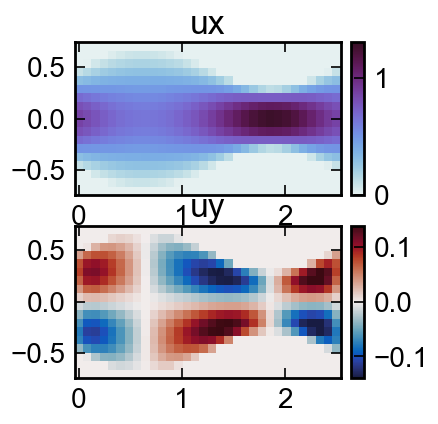

In [141]:
cmaps = [cmo.cm.dense, cmo.cm.balance, cmo.cm.dense]
# 値のプロット
vname = 'ux'
fig, axs = plt.subplots(nrows=2)

dot_size = 25
index = vnames["test"].index(vname)
ax_index = 0
axs[ax_index].set_title(vname)
f_for_plot = sample_sinusoidal.change_outside_values_to_zero(
    r_test[index]/scale, np.array(f_infer_mpcg[index]),
)
f_mesh = f_for_plot.reshape(y_num, x_num)
mappable = axs[ax_index].pcolormesh(
    x_grid,
    y_grid,
    f_mesh,
    cmap=cmaps[index],
    vmin=vlimit[0][0],
    vmax=vlimit[0][1],
    shading="nearest",
)
# mappable = axs[ax_index].scatter(r_test[index][:, 0], r_test[index][:, 1], c=f[index], marker='o',
#                                  s=dot_size, cmap=cmaps[index], vmin=vlimit[0], vmax=vlimit[1])
divider = make_axes_locatable(axs[ax_index])
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(mappable, cax=cax)
axs[ax_index].set_aspect("equal", adjustable="box")


vname='uy'

index = vnames["test"].index(vname)
ax_index = 1
axs[ax_index].set_title(vname)
f_for_plot = sample_sinusoidal.change_outside_values_to_zero(
    r_test[index]/scale, np.array(f_infer_mpcg[index]),
)
f_mesh = f_for_plot.reshape(y_num, x_num)
mappable = axs[ax_index].pcolormesh(
    x_grid,
    y_grid,
    f_mesh,
    cmap=cmaps[index],
    vmin=vlimit[1][0],
    vmax=vlimit[1][1],
    shading="nearest",
)
# mappable = axs[ax_index].scatter(r_test[index][:, 0], r_test[index][:, 1], c=f[index], marker='o',
#                                  s=dot_size, cmap=cmaps[index], vmin=vlimit[0], vmax=vlimit[1])
divider = make_axes_locatable(axs[ax_index])
cax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(mappable, cax=cax)
axs[ax_index].set_aspect("equal", adjustable="box")

In [142]:
i = 0
index_check = sample_sinusoidal.get_index_in_channel(r_test[0])
# f_check = fs[i][]

In [143]:
np.mean(np.abs(f_infer[0][index_check]-f_test[0][index_check])), np.mean(np.abs(f_infer_mpcg[0][index_check]-f_test[0][index_check]))

(0.0015456730139685806, 0.009936027717912825)

In [144]:
np.mean(np.abs(f_infer[1][index_check]-f_test[1][index_check])), np.mean(np.abs(f_infer_mpcg[1][index_check]-f_test[1][index_check]))

(0.0008383246496337868, 0.0021806900594097582)

In [145]:
np.exp(opt), np.exp(opt_mpcg)

(array([17.56417702,  1.52951439,  1.60661353,  6.03659551,  1.51012629,
         1.66478198, 21.19294147,  1.75839221,  2.68020352]),
 array([3.46101541, 2.22943062, 1.60103857, 1.87391179, 2.61719583,
        2.44102677, 3.05231149, 2.58382321, 2.42489451]))

In [146]:
opt, opt_mpcg

(Array([2.86586143, 0.42495029, 0.47412857, 1.7978402 , 0.41219328,
        0.50969417, 3.05366818, 0.56439987, 0.98589273], dtype=float64),
 Array([1.24156202, 0.80174623, 0.47065252, 0.62802811, 0.96210345,
        0.89241876, 1.11589917, 0.94927017, 0.88578802], dtype=float64))